# Clasificación de imágenes de perros y gatos

Vamos a realizar transferencia de aprendizaje utilizando el modelo preentrenado MobileNetV2 para la clasificación binaria del dataset "cats_vs_dogs".

Primero, descargamos y extraemos el dataset "cats_and_dogs" desde una URL específica que contiene carpetas de entrenamiento y validación. Luego, utilizamos la función `image_dataset_from_directory` de Keras para cargar y preprocesar automáticamente los datasets de entrenamiento y validación, configurando el tamaño de las imágenes a 160x160 píxeles y barajando los datos para el entrenamiento.

Después, cargamos MobileNetV2 preentrenado desde TensorFlow Hub, excluyendo la capa superior para adaptarlo a la tarea de clasificación binaria. Se añaden capas globales de pooling promedio y una capa densa con activación sigmoide para la clasificación final.

Realizamos un primer entrenamiento, donde se entrena el modelo congelando las capas del modelo base para evitar que se modifiquen sus pesos. Después de entrenar, se evalúa si es necesario continuar ajustando el modelo desbloqueando las capas del modelo base (`base_model.trainable = True`) y reduciendo la tasa de aprendizaje (`optimizer=Adam(1e-5)`).

El entrenamiento se realiza nuevamente (`fine_tune_epochs = 10`) para afinar el modelo en los datos específicos del dataset "cats_vs_dogs". La callback de `EarlyStopping` ayuda a evitar el sobreajuste y a optimizar la precisión del modelo final.

Finalmente, el modelo entrenado se guarda como un archivo `.h5` llamado "cats_vs_dogs_mobilenetv2.h5" para su uso futuro.

In [ ]:
# Importar librerías
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# Descargamos y preprocesamos el dataset cats_vs_dogs
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 4s 0us/step


In [ ]:
# El dataset ya tiene una carpeta de entrenamiento y validación
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
# Seleccionamos del dataset las imágenes de entrenamiento y validación
# y cambios el tamaño de cada imagen a 160x160

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# Preprocesamos los datasets
# AUTOTUNE ajusta automáticamente el número de lotes, permitiendo la precarga de lotes mientras el modelo está entrenando.

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Cargamos el modelo preentrenado MobileNetV2 sin la capa superior
base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False,
                         weights='imagenet')

# Congelamos las capas del modelo base
base_model.trainable = False

# Añadimos nuestras propias capas de clasificación
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(1, activation='sigmoid')

# Construimos el modelo final
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Compilamos el modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Definimos una callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Entrenamos el modelo
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
63/63 [==============================] - 13s 110ms/step - loss: 0.6629 - accuracy: 0.6205 - val_loss: 0.5752 - val_accuracy: 0.7070
Epoch 2/10
63/63 [==============================] - 4s 53ms/step - loss: 0.5279 - accuracy: 0.7535 - val_loss: 0.5386 - val_accuracy: 0.7300
Epoch 3/10
63/63 [==============================] - 5s 74ms/step - loss: 0.4826 - accuracy: 0.7715 - val_loss: 0.4910 - val_accuracy: 0.7700
Epoch 4/10
63/63 [==============================] - 3s 52ms/step - loss: 0.4699 - accuracy: 0.7775 - val_loss: 0.4803 - val_accuracy: 0.7650
Epoch 5/10
63/63 [==============================] - 4s 53ms/step - loss: 0.4446 - accuracy: 0.8010 - val_loss: 0.4670 - val_accuracy: 0.7890
Epoch 6/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4287 - accuracy: 0.8080 - val_loss: 0.4543 - val_accuracy: 0.7940
Epoch 7/10
63/63 [==============================] - 4s 54ms/step - loss: 0.4112 - accurac

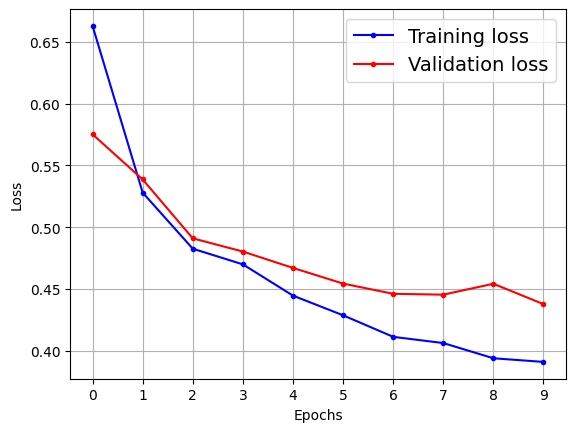

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Descongelamos las capas del modelo base y entrenamos nuevamente con una tasa de aprendizaje más baja
base_model.trainable = True
model.compile(optimizer=Adam(1e-5),  # Tasa de aprendizaje más baja
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamos el modelo nuevamente
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[early_stopping])

# # (opcional) Guardamos el modelo entrenado
# model.save('cats_vs_dogs_mobilenetv2.h5')

Epoch 10/20
63/63 [==============================] - 42s 157ms/step - loss: 0.3211 - accuracy: 0.8540 - val_loss: 0.3108 - val_accuracy: 0.8610
Epoch 11/20
63/63 [==============================] - 8s 125ms/step - loss: 0.1456 - accuracy: 0.9460 - val_loss: 0.1974 - val_accuracy: 0.9210
Epoch 12/20
63/63 [==============================] - 6s 97ms/step - loss: 0.1017 - accuracy: 0.9635 - val_loss: 0.1453 - val_accuracy: 0.9400
Epoch 13/20
63/63 [==============================] - 7s 110ms/step - loss: 0.0785 - accuracy: 0.9780 - val_loss: 0.1190 - val_accuracy: 0.9530
Epoch 14/20
63/63 [==============================] - 7s 105ms/step - loss: 0.0669 - accuracy: 0.9800 - val_loss: 0.1028 - val_accuracy: 0.9610
Epoch 15/20
63/63 [==============================] - 7s 108ms/step - loss: 0.0447 - accuracy: 0.9925 - val_loss: 0.0895 - val_accuracy: 0.9660
Epoch 16/20
63/63 [==============================] - 8s 119ms/step - loss: 0.0385 - accuracy: 0.9935 - val_loss: 0.0801 - val_accuracy: 0.9720

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


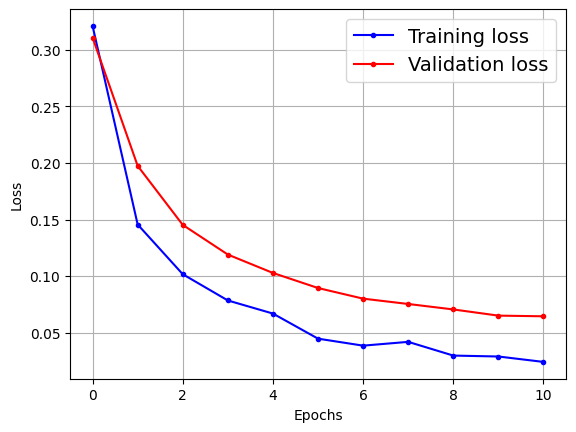

In [ ]:
plot_learning_curves(history_fine.history["loss"], history_fine.history["val_loss"])
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# import matplotlib.pyplot as plt

# # Cargamos el modelo entrenado
# model = tf.keras.models.load_model('cats_vs_dogs_mobilenetv2.h5')

# Función para mostrar imágenes y predicciones
class_names = ['cat', 'dog']

def show_predictions(dataset, model, num_images=12):
    images_shown = 0
    plt.figure(figsize=(20, 20))

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)

        for i in range(len(images)):
            if images_shown >= num_images:
                return
            ax = plt.subplot((num_images // 4) + 1, 4, images_shown + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            pred_label = class_names[int(predictions[i] > 0.5)]
            true_label = class_names[labels[i]]
            plt.title(f"Pred: {pred_label}, True: {true_label}")
            plt.axis("off")
            images_shown += 1

# Mostramos las predicciones en el número deseado de imágenes de prueba
show_predictions(validation_dataset, model, num_images=21)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report

# Generamos predicciones para todo el conjunto de validación
y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

# Convertimos las predicciones a etiquetas binarias
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Generamos el reporte de clasificación
class_names = ['cat', 'dog']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         cat       0.98      0.98      0.98       500
         dog       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

